链球数据计算
created by: 袁兴奎
==
计算步骤：
--
1. 数据导入
2. 数据整理（滤波）
3. 周期导入
4. 数据计算

需要的数据
--
1. 整体指标：速度v（分速度和合速度）,角度d，关节角度o
2. 周期划分后指标：周期时间，轨迹长度

得到的结果：
--
向量角

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math

In [2]:
def lowpassfilter(data,fre,N,cutfre):
    '''lowpass of butterworth filter'''
    win = 2*cutfre / fre
    b,a = signal.butter(N,win,'lowpass')
    fildata = signal.filtfilt(b,a,data)
    
    return fildata

In [3]:
kf_dic = {'李江燕':[43,112,165,213,259,264],'罗娜':[48,113,164,210,254,261],'王峥':[49,106,155,199,238,239]}
kf_df = pd.DataFrame(kf_dic)
kf_df

,李江燕,罗娜,王峥
0,43,48,49
1,112,113,106
2,165,164,155
3,213,210,199
4,259,254,238
5,264,261,239


In [4]:
filepath = '转换王峥_1025.TSV'
df_head = pd.read_csv(filepath,sep='\t',encoding='gbk',error_bad_lines=False,warn_bad_lines=False,header=None)
head_len = len(df_head)
df_data = pd.read_csv(filepath,encoding='gbk',sep='\t',skiprows=head_len+1,header=None) # read the data
ts = df_data.shape[0]
t = np.arange(0,ts/50,0.02) # 获取t时间轴，方便后面进行求导的操作

In [5]:
# 修改表头
headers = ['颅顶点','第七颈椎','胸骨下点','脐点','耻骨点','左肩峰','左肘','左腕','左中指尖','左髋','左膝','左踝' ,'左足跟' ,'左趾尖' ,'右肩峰' ,'右肘' ,'右腕' ,'右中指尖' ,'右髋' ,'右膝' ,'右踝' ,'右足跟' ,'右趾尖' ,'链球' ,'重心']
newheaders = []
for h in headers:
    x = h + 'x'
    y = h + 'y'
    z = h + 'z'
    newheaders.append(x)
    newheaders.append(y)
    newheaders.append(z)
newheaders
df_data.columns = newheaders
df_data

,颅顶点x,颅顶点y,颅顶点z,第七颈椎x,第七颈椎y,第七颈椎z,胸骨下点x,胸骨下点y,胸骨下点z,脐点x,...,右足跟z,右趾尖x,右趾尖y,右趾尖z,链球x,链球y,链球z,重心x,重心y,重心z
0,-806.19118,184.23296,1549.44526,-825.47292,137.13435,1388.08257,-903.35085,286.47756,1189.73730,-918.96292,...,-23.01571,891.88867,723.24894,-245.26033,-2074.71445,467.10750,2051.51140,-567.06948,132.85500,987.50387
1,-809.30508,192.27210,1545.47841,-829.01926,127.12871,1360.12742,-922.20326,301.96896,1159.72909,-912.39697,...,-19.42033,-918.48462,484.45583,-13.43259,487.73315,1134.62822,1588.08892,-944.63655,199.55623,939.61586
2,-819.97147,224.62457,1539.48880,-843.49911,137.53971,1346.73246,-899.26562,293.88244,1150.46125,-912.59568,...,-17.22546,-926.58587,483.12755,-10.74829,408.89336,1174.63521,1531.53790,-943.98240,204.90611,933.69464
3,-823.30966,224.54836,1533.96606,-841.34159,145.99208,1342.65905,-896.96106,297.41944,1143.14014,-873.08842,...,-18.01884,-970.95668,481.39443,-4.11749,363.89417,1259.49256,1488.32549,-935.17543,203.43858,929.64819
4,-840.26677,223.52701,1529.64824,-842.08362,156.91824,1341.56438,-863.48874,295.53115,1133.72217,-873.20661,...,-19.20519,-956.89605,483.28226,-6.27962,294.55081,1317.79906,1463.79017,-930.06127,202.56652,924.19156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,877.95152,384.45713,1611.52051,774.35084,292.85425,1455.21585,975.25123,21.87385,1276.39303,1012.51160,...,101.01833,801.31204,167.03140,-33.54668,1656.55631,-1430.36743,1981.50601,931.93871,54.58381,1061.37354
247,864.25493,390.34439,1611.72931,747.71011,291.24669,1451.84873,955.24197,35.50022,1273.51697,1017.43911,...,101.01833,809.98247,167.83541,-32.72368,1869.40491,-1417.55228,2170.70269,928.92622,68.57075,1062.49623
248,840.87901,339.36533,1612.47863,739.51231,272.85607,1471.42910,942.30227,70.59256,1277.74328,1017.43911,...,106.14228,809.98247,167.83541,-32.72368,1985.83114,-1349.06728,2300.31731,927.06305,75.37121,1067.64428
249,823.34134,320.38795,1619.60738,725.05729,271.76391,1474.90324,935.22214,77.52070,1278.31127,993.70914,...,106.16820,809.98247,167.83541,-32.72368,2030.71455,-1301.84138,2362.85901,921.93027,80.34443,1073.72553


In [6]:
# 对所有数据进行滤波,fil_df就是新的滤波后的数据
fil_df = pd.DataFrame()
for c in df_data:
    dc = df_data[c]
    fil_dc = lowpassfilter(dc,50,4,10)
    fil_df[c] = fil_dc

In [7]:
# 进行计算，对所有数据进行求导计算速度
# 求导采用的是gradient求导，中心差分方法
dx = 0.02
v_values = np.gradient(fil_df.T,dx,t)[1].T
# 将计算之后的数据写入到文件中
v_df = pd.DataFrame(v_values,columns=newheaders)
# v_df.to_csv(filepath[:-4]+'.csv',encoding='gbk',index=None)

In [8]:
# 进行相关角度的计算
def dangle(vector2):
    '''计算两个向量之间的夹角（方向角）'''
    a = np.array(vector2[0])
    b = np.array(vector2[1])
    
    a_b = np.dot(a,b) # 将两个向量点乘
    cos_ab = a_b / (np.linalg.norm(a) * np.linalg.norm(b)) # 除以两个向量的模就是cosα
    # 由于某些数据表示原因有大于1的情况，所以进行排除
    if cos_ab > 1:
        cos_ab = 1
    angle = math.degrees(math.acos(cos_ab))
    
    return angle

In [9]:
# 将所有的点都存到字典中，这样方便进行计算
point_dic = {} # {'point_name':[x_list,y_list,z_list]}
for k in df_data:
    point_dic[k[:-1]] = []
for k in df_data:
    point_dic[k[:-1]].append(np.array(df_data[k]))
for k in point_dic:
    point_dic[k] = np.array(point_dic[k])

In [10]:
point_dic.keys()

dict_keys(['颅顶点', '第七颈椎', '胸骨下点', '脐点', '耻骨点', '左肩峰', '左肘', '左腕', '左中指尖', '左髋', '左膝', '左踝', '左足跟', '左趾尖', '右肩峰', '右肘', '右腕', '右中指尖', '右髋', '右膝', '右踝', '右足跟', '右趾尖', '链球', '重心'])

In [11]:
# 找到所有的向量，进行相关的计算
def cal_all_two_ange(vetor1,vetor2):
    cat_two = zip(list(vetor1.T),list(vetor2.T))
    ct_li = list(cat_two)
    res = map(dangle,ct_li)
    two_angle = np.array(list(res))
    
    return two_angle

data_res_dic = {}
# 一些关节点的命名
mid_sh = (point_dic['左肩峰'] + point_dic['右肩峰'])/2
mid_hip = (point_dic['左髋'] + point_dic['右髋'])/2
# 计算肩髋角
vector_lr_sh = point_dic['左肩峰'] - point_dic['右肩峰']
vector_lr_hip = point_dic['左髋'] - point_dic['右髋']
sh_hip_angle = cal_all_two_ange(vector_lr_sh,vector_lr_hip)
# 计算髋关节角度
vector_trunk = mid_sh - mid_hip
vector_l_kh = point_dic['左膝'] - point_dic['左髋']
vector_r_kh = point_dic['右膝'] - point_dic['右髋']
hip_angle_l = cal_all_two_ange(vector_trunk,vector_l_kh)
hip_angle_r = cal_all_two_ange(vector_trunk,vector_r_kh)
# 计算左膝关节角度
vector_l_ak = point_dic['左踝'] - point_dic['左膝']
vector_l_hk = - vector_l_kh # 与上面那个膝髋相反
knee_angle_l = cal_all_two_ange(vector_l_ak,vector_l_hk)
# 计算躯干倾角
# 与水平面的夹角计算需要先得出水平面的法向量
vector_ver_T = np.zeros((3,vector_trunk.shape[1]),dtype=int)
vector_ver_T[2,:] = np.ones((1,vector_trunk.shape[1])) # 全是(0.0,1)的单位向量
trunk_angle = 90 - cal_all_two_ange(vector_trunk,vector_ver_T)
# 计算肩链角（肩点和链球点连线与水平面之间的夹角）
vector_b_midsh = point_dic['链球'] - mid_sh
vector_hc = point_dic['右中指尖'] - point_dic['第七颈椎']
vector_rsc = point_dic['右肩峰'] - point_dic['第七颈椎']
shoulder_trunk_angle = cal_all_two_ange(vector_rsc,vector_hc) # 角度可能是负值，负值表示背对着前方
# 将计算结果放入字典进行存储
data_res_dic['肩髋角'] = sh_hip_angle
data_res_dic['左髋关节角'] = hip_angle_l
data_res_dic['右髋关节角'] = hip_angle_r
data_res_dic['左膝关节角'] = knee_angle_l
data_res_dic['躯干倾角'] = trunk_angle
data_res_dic['肩链角'] = shoulder_trunk_angle

In [12]:
# 所有的关节角度数据
angle_data_df = pd.DataFrame(data_res_dic)

In [13]:
# 进行球轨迹长度的计算
df_harmer = pd.DataFrame(point_dic['链球']).T
df_harmer2 = df_harmer.shift(1)
df_harmer_space = df_harmer - df_harmer2
# start = 1 # 设置了周期截取
# end = -1 # 周期截取
# harmer_length = np.sum(np.sqrt(np.square(df_harmer_space.iloc[start:end,:]).mean(axis=1)))* 0.001 # units m

In [14]:
# 计算和速度
v_bs = np.sqrt(np.sum(np.square(v_df.iloc[:,-6:-3]),axis=1))
v_gs = np.sqrt(np.sum(np.square(v_df.iloc[:,-3:]),axis=1))
v_ws = np.sqrt(np.sum(np.square(v_df.iloc[:,21:24]),axis=1))
v_fs = np.sqrt(np.sum(np.square(v_df.iloc[:,24:27]),axis=1))

In [15]:
# 将最后需要的数据进行组合，放到一个df表格中 
v_b = v_df.iloc[:,-6:-3]
v_g = v_df.iloc[:,-3:]
v_w = v_df.iloc[:,21:24]
v_f = v_df.iloc[:,24:27]
all_need_df = pd.concat([angle_data_df,v_b,v_bs,v_g,v_gs,v_w,v_ws,v_f,v_fs],axis=1)

In [16]:
all_need_df.columns = [  '肩髋角', '左髋关节角', '右髋关节角', '左膝关节角',  '躯干倾角', '肩链角',   '链球x',   '链球y',   '链球z',
             '链球合',   '重心x',   '重心y',   '重心z', '重心合',   '左腕x',   '左腕y',   '左腕z',
             '左腕合', '左中指尖x', '左中指尖y', '左中指尖z',  '左中指尖合']

In [17]:
v_wri = v_df.iloc[:,21:27]

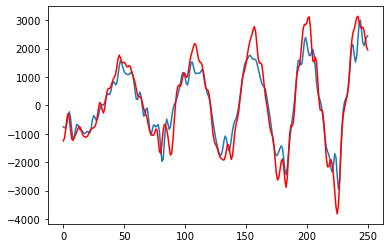

In [18]:
plt.plot(v_wri.iloc[:,2])
plt.plot(v_wri.iloc[:,5],color='r') # 从图上面可以看到，手腕点的速度会低一点，中指的速度会比较平滑，但是峰值会高一些

In [19]:
# 进行周期划分和相关数据的计算
all_need_df

,肩髋角,左髋关节角,右髋关节角,左膝关节角,躯干倾角,肩链角,链球x,链球y,链球z,链球合,...,重心z,重心合,左腕x,左腕y,左腕z,左腕合,左中指尖x,左中指尖y,左中指尖z,左中指尖合
0,45.187251,108.595911,116.994755,115.776208,36.419255,97.491396,88182.806433,23933.679920,-17230.186700,92983.373345,...,-1754.842795,13560.846617,-712.914619,1233.574881,-756.317978,1613.062654,-456.901622,1003.232198,-1253.217259,1669.067834
1,87.814881,155.694063,162.133950,112.231927,75.056459,105.000256,67437.417549,19217.837757,-13794.605904,71466.227869,...,-1414.376143,10423.296541,-815.462883,1182.502099,-788.074960,1638.399545,-702.059975,1111.569132,-1144.785341,1743.274970
2,31.043195,138.984547,134.043076,113.001900,62.201812,25.419627,24086.654482,9316.215575,-6505.656639,26632.355605,...,-703.058945,3827.984009,-965.383785,1055.443809,-789.726707,1633.889763,-1222.175584,1296.314962,-836.548473,1968.237533
3,29.545435,138.217718,133.926623,113.940873,61.117132,23.090201,-7229.051572,2044.281746,-1015.862074,7580.913549,...,-185.593986,1081.100853,-884.499662,867.450208,-623.698691,1387.014626,-1640.162642,1282.122629,-459.840853,2132.000360
4,36.846670,136.187809,132.923428,113.038477,59.405580,26.055337,-12402.151498,652.365287,99.602305,12419.696569,...,-82.793130,1917.033695,-579.467995,592.793593,-348.344230,899.183576,-1821.672944,971.836447,-281.826461,2083.838897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,7.774223,160.215279,144.911911,153.561390,60.617121,62.853195,9363.307766,1874.245480,8344.580468,12681.338716,...,314.606219,391.329893,2036.503855,4292.660825,2220.588156,5244.549234,3203.267563,5185.262905,2754.045834,6688.246626
247,6.664639,159.618652,142.387418,144.929405,61.443466,54.357435,7705.255715,2079.861747,7212.163850,10756.955792,...,227.516935,437.853363,2192.243094,4979.288740,2102.882706,5832.783368,3242.422596,6662.982864,2653.156252,7870.697748
248,11.064005,163.218910,144.726177,143.899625,63.405522,54.434501,4866.204652,2531.649980,5192.848801,7553.467946,...,195.626762,491.302732,2184.760247,4671.078657,2238.545910,5621.675991,2641.434414,6271.516266,2372.163712,7206.681117
249,15.676801,168.698425,146.279966,144.135197,65.458016,42.402428,2106.107254,3013.475293,3079.654864,4795.935278,...,208.405727,498.769980,1971.667319,4103.703992,2395.815911,5144.685836,1914.552531,4823.151343,2078.256292,5589.941814


In [20]:
kf_od_dic = {'李江燕':[84,142,198,242,-1,-1],'罗娜':[82,141,190,236,-1,-1],'王峥':[83,134,180,224,-1,-1]}
kf_od_df = pd.DataFrame(kf_od_dic)
kf_od_df

,李江燕,罗娜,王峥
0,84,82,83
1,142,141,134
2,198,190,180
3,242,236,224
4,-1,-1,-1
5,-1,-1,-1


In [21]:
# 进行斜切角的计算
# 先进行周期内的高点和低点的寻找
# 所有的数据都在 all_need_df里面，在这个数据里面寻找就可以了,周期在 kf_df里面
pname = filepath[2:-9]
p_kf = kf_df[pname]
p_od_kf = kf_od_df[pname]

In [22]:
kf_od_df

,李江燕,罗娜,王峥
0,84,82,83
1,142,141,134
2,198,190,180
3,242,236,224
4,-1,-1,-1
5,-1,-1,-1


In [23]:
p_kf

0     49
1    106
2    155
3    199
4    238
5    239
Name: 王峥, dtype: int64

In [24]:
p_od_kf

0     83
1    134
2    180
3    224
4     -1
5     -1
Name: 王峥, dtype: int64

In [25]:
res_find_data = {'cut_cycle_data':[],'轨迹长':[],'cycle_res':{'最大值':{},'最小值':{},'斜切角度x':{},'斜切角度xy':{}}}
cp_df = all_need_df.copy()

# 将每个时刻的数据添加到df中
for c in range(0,len(p_kf)-1):
    # s到n这个阶段
    s = p_kf[c]-1
    n = p_kf[c+1]-1
    mid_k = p_od_kf[c]-1 # 每一圈的节点
    harmer_length = np.sum(np.sqrt(np.square(df_harmer_space.iloc[s:n,:]).mean(axis=1)))* 0.001 # units m 轨迹长
    single_harmer_l = np.sum(np.sqrt(np.square(df_harmer_space.iloc[s:mid_k,:]).mean(axis=1)))* 0.001
    res_find_data['cut_cycle_data'].append(cp_df.iloc[s:n,:])
    res_find_data['轨迹长'].append(harmer_length)
    res_find_data['轨迹长'].append(single_harmer_l) # 将前半段的双支撑阶段的数据加上去
    all_need_df = all_need_df.append(cp_df.iloc[s,:])

In [26]:
# 计算周期内的一些数据
for i,oc in enumerate(res_find_data['cut_cycle_data']):
    amax = oc.max()
    amin = oc.min()
    cy_name = '第'+ str(i+1) + '圈'
    res_find_data['cycle_res']['最大值'][cy_name] = amax
    res_find_data['cycle_res']['最小值'][cy_name] = amin


In [27]:
# 计算斜切角
for i in res_find_data['cycle_res']['最小值']:
    print(i)
    max_p = np.array(res_find_data['cycle_res']['最大值'][i]['链球x':'链球z'])
    min_p = np.array(res_find_data['cycle_res']['最小值'][i]['链球x':'链球z'])
    vector_xn_p = max_p-min_p
    print(vector_xn_p)
    ves = [vector_xn_p,[0,1,0]] # 和x轴（xz面）
    zves = [vector_xn_p,[0,0,1]] # 和水平面的夹角（xy）
    xn_angle = 90-dangle(ves) # 如果角度<0那么偏右
    xy_angle = 90-dangle(zves)
    res_find_data['cycle_res']['斜切角度x'][i] = xn_angle
    res_find_data['cycle_res']['斜切角度xy'][i] = xy_angle

第1圈
[19340.7259304  18719.40153344  9469.18719606]
第2圈
[18194.72534596 21102.90051161 12930.44617062]
第3圈
[18227.9876929  23684.51968776 16255.42196593]
第4圈
[19868.03321405 25383.67149552 18501.24943562]
第5圈
[0. 0. 0.]


<ipython-input-8-d3030afd764a>:8: RuntimeWarning: invalid value encountered in double_scalars
  cos_ab = a_b / (np.linalg.norm(a) * np.linalg.norm(b)) # 除以两个向量的模就是cosα


In [28]:
res_find_data['cycle_res']['斜切角度x']['空1'] = 0
res_find_data['cycle_res']['斜切角度x']['空2'] = 0
res_find_data['cycle_res']['斜切角度x']['空3'] = 0
res_find_data['cycle_res']['斜切角度x']['空4'] = 0
res_find_data['cycle_res']['斜切角度x']['空5'] = 0

In [29]:
guiji_df = pd.DataFrame(res_find_data['轨迹长'],columns=['轨迹长']).T
guiji_df.columns = res_find_data['cycle_res']['斜切角度x'].keys()

In [30]:
xieqie_x_df = pd.DataFrame(res_find_data['cycle_res']['斜切角度x'],index=['斜切角度x'])
xieqie_xy_df = pd.DataFrame(res_find_data['cycle_res']['斜切角度xy'],index=['斜切角度xy'])

In [31]:
guiji_df

,第1圈,第2圈,第3圈,第4圈,第5圈,空1,空2,空3,空4,空5
轨迹长,5.919601,3.30053,6.075975,3.295363,6.040335,3.260475,5.634427,3.454695,0.150589,1.791655


In [32]:
need_df2 = pd.concat([xieqie_x_df,xieqie_xy_df,guiji_df])

In [33]:
# 进行最大值和最小值的合并
max_df = pd.DataFrame(res_find_data['cycle_res']['最大值']).T
min_df = pd.DataFrame(res_find_data['cycle_res']['最小值']).T
all_need_df3 = pd.concat([all_need_df,max_df,min_df],axis=0)

In [34]:
all_need_df_fina = pd.concat([all_need_df3,need_df2],axis=0)
all_need_df_fina

,肩髋角,左髋关节角,右髋关节角,左膝关节角,躯干倾角,肩链角,链球x,链球y,链球z,链球合,...,第1圈,第2圈,第3圈,第4圈,第5圈,空1,空2,空3,空4,空5
0,45.187251,108.595911,116.994755,115.776208,36.419255,97.491396,88182.806433,23933.679920,-17230.186700,92983.373345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,87.814881,155.694063,162.133950,112.231927,75.056459,105.000256,67437.417549,19217.837757,-13794.605904,71466.227869,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,31.043195,138.984547,134.043076,113.001900,62.201812,25.419627,24086.654482,9316.215575,-6505.656639,26632.355605,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29.545435,138.217718,133.926623,113.940873,61.117132,23.090201,-7229.051572,2044.281746,-1015.862074,7580.913549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,36.846670,136.187809,132.923428,113.038477,59.405580,26.055337,-12402.151498,652.365287,99.602305,12419.696569,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
第4圈,13.089757,153.324369,144.269672,112.843599,67.937078,33.456140,-10921.146198,-13014.624121,-10434.137221,10646.224719,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
第5圈,32.887384,165.414269,155.478523,152.428847,64.741752,107.313823,6543.688964,-8479.788087,6468.974065,12512.965145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
斜切角度x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.999784,43.392697,44.120175,43.075979,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
斜切角度xy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.382028,24.894234,28.541821,29.853936,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
all_need_df_fina.to_csv(filepath[:-4]+'_all_res.csv',encoding='gbk')